# Goal
Use pywinauto to automate simple acquisition steps, like Velox, Sherpa, move stage. This notebook implements a simple serpentine acquisition task.

Chia-Hao Lee, 20210801

## Depencies
1. pywinauto (https://pywinauto.readthedocs.io/en/latest/contents.html)
2. temscript (https://github.com/niermann/temscript)
3. Object inspection tool (e.g. inspect.exe, https://github.com/blackrosezy/gui-inspect-tool)

## Checklist before you start
1. Open the Velox and Sherpa beforehand, and place Velox acquisition on the right screen fully.

2. Setup your acquisition parameters
    - mag, px sampling
    - probe current, detector B/C, detector type
    - dwell, frame number
    - Filename pattern, Autosave folder path

3. Make sure the specified acquisition range is "SAFE" for the stage

## Introduction
The goal is simple. Control multiple applications with a single script to achieve large-scale automatic acquisition. However, it's not easy to connect different applications when there's no clear API for sripting languages to interact with. 'Pywinauto' provides a simple way to interact with Microsoft Windows GUI, as simple as sending the mouse/keyboard actions for you. With the help of pywinauto, we can control user interface (UI), Sherpa (for aberration correction), and Velox (for acquisition). The moveStage function is implemented by calling the 'temscript'.

## Citation
If you find any part of this script helpful, please cite: DOI: 10.1017/S1431927621003482

## Worklog
- 20210216: Modify acquisition steps, make it into funcions
- 20210219: Add a user input to pause/resume/quit the loop (threading)
- 20210222: Add scan rotation, add control to UI (Stage Piezo)
- 20210316: Add tmescript (change optics, mode, move stage), remove double-click on Velox to move stage function
- 20210413: Add setStemMag

## TODO
1. Catch Sherpa result so that the wait time can be self-determined
2. Implement a beam shower routine

In [1]:
# Import packages
from pywinauto import Application, mouse,keyboard, clipboard
import temscript as ts
import time
from time import sleep
import threading
import numpy as np
import sys
import matplotlib.pyplot as plt

## 01. Velox control setup

In [2]:
#Connect to Velox
appVelox = Application(backend='uia').connect(title=u'Acquisition - Velox')
tool_bar = appVelox.top_window().Toolbar

#Select and insert Detectors
HAADF = tool_bar.HAADF #Switching to HAADF will automatically start viewing
TEM = tool_bar.TEM

#Scan Rotation controls
ScanRotL90 = tool_bar.DetectorsCustom3.Button3
ScanRotReset = tool_bar.DetectorsCustom3.Button4
ScanRotR90 = tool_bar.DetectorsCustom3.Button5


#stem_imaging tab controls 
#Note that actual function depends on how you setup your imaging tabs in Velox
beam_blank = tool_bar.Custom10.checkBox0
focus_box = tool_bar.Custom10.checkBox2
search = tool_bar.Custom10.checkBox3
preview = tool_bar.Custom10.checkBox4
acquire = tool_bar.Custom10.checkBox5
video = tool_bar.Custom10.checkBox6


## Velox function list

#Unblank
beam_blank.click_input()
bb={"0":"On", "1":"Off"}
print("The beam is " + bb[str(beam_blank.get_toggle_state())])

#Acquire a Velox image
acquire.click_input()

#Acquire a Velox video (image stack)
video.click_input()

## 02. Sherpa control setup

In [3]:
#Connect to Sherpa
SherpaPID=18644
#Note: Use Inspect.exe UIA mode to check process ID (PID), it's changing everytime you restart the target application
appSherpa = Application(backend='uia').connect(process=SherpaPID)
#appSherpa.mainWindow.Tune.print_control_identifiers()

#OptiSTEM controls
C1A1 = appSherpa.mainWindow.Tune.Button1
A2B2 = appSherpa.mainWindow.Tune.Button2

# These funcitons are still under construction
def getSherpaLog():
    clipboard.EmptyClipboard()
    appSherpa.mainWindow.logDock.copyLoggingButton.click()
    sleep(0.15) #It takes some time to really copy the text
    log = clipboard.GetData(format_id=13)
    return log

def clearSherpaLog():
    appSherpa.mainWindow.logDock.clearLoggingButton.click()
    return

## To do: Fix the Sherpa Status bar detect

### Sherpa success log:
converged, # cycles = 2

Final result: C1=1.27nm A1r=1.54nm A1i=2.30nm

C1/A1 finished

### Sherpa failed log:
OS2 ended

Error during 'A2/B2': Maximum # iterations reached

## Sherpa funciton list

### Click C1A1
C1A1.click()

### Click A2B2
A2B2.click()

Note: A2B2 button is actually doing C1A1+A2B2 tunning

## 03. UI control setup 
Note: For SerpentineAcquisition, these cells are not necessary. It was here just for completeness.

In [ ]:
#Connect to User interface
UIPID=6680
appUI = Application(backend='win32').connect(process=UIPID)

In [ ]:
#Note: Open the flapout of Stage Piezo tab
ResetX = appUI.StagePiezo.Reset1
ResetY = appUI.StagePiezo.Reset2
ResetZ = appUI.StagePiezo.Reset3

MovePiezo = appUI.StagePiezo.MoveOptionDlg

MinusX = MovePiezo.Minus1
PlusX = MovePiezo.Plus1
MinusY = MovePiezo.Minus2
PlusY = MovePiezo.Plus2
MinusZ = MovePiezo.Minus3
PlusZ = MovePiezo.Plus3


## 04. temscript setup (move stage, STEM magnification)

In [4]:
#Setup temscript

tem = ts.Microscope()
instrument = ts.GetInstrument()
currentStagePos = tem.get_stage_position()
currentMag_STEM = instrument.Illumination.StemMagnification
#Directly modify instrument.Illumination.StemMagnification to change the Mag

In [5]:
def StepHoriz(distance_nm):
    '''
    Move stage in X direction
    Input:
        distance: unit: nanometers
    '''
    distance_m = distance_nm * 10**-9
    currentStagePos = tem.get_stage_position()
    newStagePos = currentStagePos["x"] + distance_m
    
    if abs(newStagePos)<950*10**-6: #New position must within 950um
        tem.set_stage_position(x=newStagePos)
    else:
        print("Move stage step too big! Please input distance in nm!")
    return

def StepVerti(distance_nm):
    '''
    Move stage in Y direction
    Input:
        distance: unit: nanometers
    '''
    distance_m = distance_nm * 10**-9
    currentStagePos = tem.get_stage_position()
    newStagePos = currentStagePos["y"] + distance_m
    
    if abs(newStagePos)<950*10**-6: #New position must within 950um
        tem.set_stage_position(y=newStagePos)
    else:
        print("Move stage step too big! Please input distance in nm!")
    return

def setStemMag(mag, verbose = True):
    currentMag_STEM = instrument.Illumination.StemMagnification
    if verbose:
        print("Original STEM mag is", currentMag_STEM)
        
    instrument.Illumination.StemMagnification = mag
    currentMag_STEM = instrument.Illumination.StemMagnification
    if verbose:
        print("Current STEM mag is", currentMag_STEM)
    return

In [6]:
LowMag = 40000
C1A1Mag = 3600000
HighMag = 3600000
#setStemMag(C1A1Mag, verbose=True)

In [7]:
def SleepCountDown(CountDown):
    for t in reversed(range(0,int(CountDown))):
        sys.stdout.write(str(t+1)+' ')
        sys.stdout.flush()
        sleep(1)

## 05. Main acquisition script

### 05.01 Setup the acquisition pattern and step size, get a feeling of the total size/time of the dataset

In [12]:
#Time unit: Sec
C1A1Wait    = 15 #15
AcquireWait = 17 #32 Need to be slightly larger than the frame time in Velox
StageWait   = 60 #60

#FOV and step size
FOVnm = 21.57 #Input the value in Velox properties, nm
StepSize =  80 #Unit: nm
print('Step size is %s nm\n' %(StepSize))

#Acquisition Pattern
NumHoriz = 7 #Number of sample positions on horizontal direction
NumVerti = 7 #Number of sample positions on vertical direction
NumUturn = NumVerti//2 
NumRemain = NumVerti%2
print("NumHoriz, NumVerti = ",(NumHoriz, NumVerti))
print("NumUturn = ",NumUturn)
print("NumRemain = ",NumRemain)

#Acquisition time
TotalTime = (C1A1Wait + AcquireWait + StageWait)*NumHoriz*NumVerti
print("\nTotal acquisition time is expected to be {} hours {} mins for {} images".
      format(int(TotalTime/3600), int((TotalTime%3600)/60), NumHoriz*NumVerti))
print("Actual scanning time is {}% of the total time".format(AcquireWait*NumHoriz*NumVerti/TotalTime*100))

#Acquisition area
length = (NumHoriz-1)*StepSize+FOVnm
height = (NumVerti-1)*StepSize+FOVnm
area   = length*height 

print("\nEstimated covering size for %s images = %.0f nm * %.0f nm = %.0f nm^2 " %(NumHoriz*NumVerti, length,height,area) )
print("Estimated number of atoms in WSe2 will be %.2E " %(32*area)) #32atoms/nm^2

Step size is 80 nm

NumHoriz, NumVerti =  (7, 7)
NumUturn =  3
NumRemain =  1

Total acquisition time is expected to be 1 hours 15 mins for 49 images
Actual scanning time is 18.478260869565215% of the total time

Estimated covering size for 49 images = 502 nm * 502 nm = 251572 nm^2 
Estimated number of atoms in WSe2 will be 8.05E+06 


### 05.02 Test case: Serial acquisition (horizontal)

In [ ]:
"""
for i in range(2):
    print("\n")
    print("\n*** C1A1 at Position", i+1, "***")
    C1A1.click()
    SleepCountDown(C1A1Wait) #Wait for Sherpa to finish
    
    print("\n*** Acquiring at Position", i+1, "***")
    acquire.click_input()
    sleep(AcquireWait) #Wait for acquisition to finish
    
    print("*** Moving stage to Position", i+2, ",please wait! ***")
    StepHoriz(StepSize)
    SleepCountDown(StageWait) #Wait for stage drift to settle down

print("\n*** Acquistion finished! ***\n")
"""

### 05.03 Defining acquisition functions

In [9]:
#Note: To minimize the distortion along slow scan direction, 
#      serpentine from left to right is preferred.

def ScanHoriz(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize):
    print("\n")
    print("\n*** C1A1 at Position", idx+1, "***")
    setStemMag(C1A1Mag, verbose=True)
    C1A1.click()
    SleepCountDown(C1A1Wait) #Wait for Sherpa to finish
    
    print("*** Acquiring at Position", idx+1, "***")
    #Acquire the low mag
    #setStemMag(LowMag, verbose=True)
    #acquire.click_input()
    #sleep(2.5)
    
    #Acquire the video
    setStemMag(HighMag, verbose=True)
    video.click_input()
    sleep(AcquireWait) #Wait for acquisition to finish
    
    print("*** Moving stage to Position", idx+2, ",please wait! ***")
    StepHoriz(StepSize)
    SleepCountDown(StageWait) #Wait for stage drift to settle down
    idx+=1
    
    coord_list.append(coord)
    coord=coord + np.array([StepSize,0])
    return idx, coord

def ScanVerti(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize):
    print("\n")
    print("\n*** C1A1 at Position", idx+1, "***")
    setStemMag(C1A1Mag, verbose=True)
    C1A1.click()
    SleepCountDown(C1A1Wait) #Wait for Sherpa to finish
    
    print("*** Acquiring at Position", idx+1, "***")
    #Acquire the low mag
    #setStemMag(LowMag, verbose=True)
    #acquire.click_input()
    #sleep(2.5)
    
    #Acquire the video
    setStemMag(HighMag, verbose=True)
    video.click_input()
    sleep(AcquireWait) #Wait for acquisition to finish
    
    print("*** Moving stage to Position", idx+2, ",please wait! ***")
    StepVerti(-StepSize)
    SleepCountDown(StageWait) #Wait for stage drift to settle down
    idx+=1
    
    coord_list.append(coord)
    coord=coord + np.array([0,-StepSize])
    return idx, coord

def ScanUturn(NumHoriz, idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize):
    
    #Scanning from left to right and make an U turn 
    print("Let's start scanning right!")
    
    NumRight = 1
    while NumRight < (NumHoriz):
        if UserInput.Input=="Pause":
            continue #This will let the while loop keep repeating itself without actually doing thing, it's an equivalent pause
        elif UserInput.Input=="Quit":
            print("Just quit the ScanRight!")
            #UserInput.Input='' #Reset the UserInput
            break
        else:
            idx, coord = ScanHoriz(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
            NumRight+=1
    if UserInput.Input!="Quit":        
        idx, coord = ScanVerti(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
        print("Made an U turn, scanning left!")
    
    NumLeft = 1
    while NumLeft < (NumHoriz):
        if UserInput.Input=="Pause":
            continue #This will let the while loop keep repeating itself without actually doing thing, it's an equivalent pause
        elif UserInput.Input=="Quit":
            print("Just quit the ScanLeft!")
            #UserInput.Input='' #Reset the UserInput
            break
        else:
            idx, coord = ScanHoriz(idx, coord, C1A1Wait, AcquireWait, StageWait, -StepSize)
            NumLeft+=1
    if UserInput.Input!="Quit":
        idx, coord = ScanVerti(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
        
    return idx, coord

### 05.04 Define threading and main acquisition funciton

In [10]:
class CaptureInput():
    Input = ""

class tt(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
    def run(self):
        while True:
            UserInput.Input = input('Enter "Pause" to Pause, enter any key to Resume, enter "Quit" to quit')
            if UserInput.Input =="Quit":
                break
def SerpentineAcquisition(idx, coord):
    #This thread to capture input for controlling the main()
    inputThread = tt()
    inputThread.start()
    
    #Iterating scanUturn
    NumU = 1
    while NumU <= (NumUturn):
        if UserInput.Input=="Quit":
            print("Just quit the ScanUturn!")
            #UserInput.Input='' #Reset the UserInput
            break
        else:
            idx, coord = ScanUturn(NumHoriz, idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
            NumU+=1
    
    #The edge case for having odd number of NumVerti
    if NumRemain==1: 
        print("Let's start scanning right!")
        h=1
        while h < (NumHoriz):
            if UserInput.Input=="Quit":
                print("Just quit the last line!")
                #UserInput.Input='' #Reset the UserInput
                break
            else:
                idx, coord = ScanHoriz(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
                h+=1
        idx, coord = ScanVerti(idx, coord, C1A1Wait, AcquireWait, StageWait, StepSize)
                
    print("\n*** Serpentine acquistion finished! ***\n")
    print("Please input 'Quit' to end the UserInput thread")
    return

### 05.05 Perform Serpentine Acquisition

In [ ]:
idx=0 #Global index for positions
coord = np.array([0,0]) #Coord for the positions
coord_list = []
tStart=time.time()

#Initiate the CaptureInput object
UserInput = CaptureInput()

#Run the main program with an additional thread to capture the input
SerpentineAcquisition(idx, coord)          

tEnd=time.time()
print("Actual acquisition time is ", tEnd-tStart, "sec")
print("Acquired {} images!".format(len(coord_list)))

Let's start scanning right!



*** C1A1 at Position 1 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 *** Acquiring at Position 1 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
*** Moving stage to Position 2 ,please wait! ***
60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 


*** C1A1 at Position 2 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 *** Acquiring at Position 2 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
*** Moving stage to Position 3 ,please wait! ***
60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 


*** C1A1 at Position 3 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
1

*** Moving stage to Position 20 ,please wait! ***
60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 


*** C1A1 at Position 20 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 *** Acquiring at Position 20 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
*** Moving stage to Position 21 ,please wait! ***
60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 


*** C1A1 at Position 21 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 *** Acquiring at Position 21 ***
Original STEM mag is 3600000.0
Current STEM mag is 3600000.0
*** Moving stage to Position 22 ,please wait! ***
60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 3

### 05.06 Plot the acquisition pattern

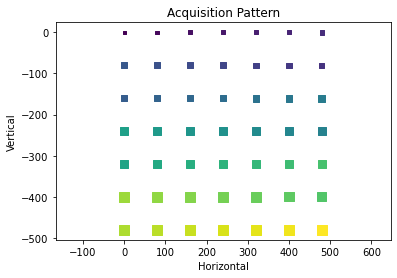

In [14]:
(x,y) = zip(*coord_list)

plt.subplots()
plt.title("Acquisition Pattern")
plt.scatter(x,y, marker='s', s=2*np.arange(len(x))+10, c=np.arange(len(x)), cmap="viridis")
plt.set_ylim=(np.min(y), np.max(y))
plt.set_xlim=(np.min(x), np.max(x))
#plt.gca().invert_yaxis()
plt.xlabel("Horizontal")
plt.ylabel("Vertical")
plt.axis('equal')
plt.show()